In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore

cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [2]:
ACTIVITIES = ["walk"]
POSITIONS = [
    "dom_hand"
]

In [3]:
def recording_to_dataframe(record):
    rows = []

    samples = record.get("samples", [])
    if not samples:
        return pd.DataFrame()

    for sample in samples:
        accel = sample.get("accelerometer", {})
        gyro = sample.get("gyroscope", {})
        rot = sample.get("rotation", {})

        rows.append({
            "time": sample.get("timestamp"),
            "ax": accel.get("x"),
            "ay": accel.get("y"),
            "az": accel.get("z"),
            "gx": gyro.get("x"),
            "gy": gyro.get("y"),
            "gz": gyro.get("z"),
            "rx": rot.get("x"),
            "ry": rot.get("y"),
            "rz": rot.get("z"),
            "rw": rot.get("w"),
        })

    return pd.DataFrame(rows).sort_values("time").reset_index(drop=True)

In [4]:
def fetch_motion_data():
    recordings_list = []
    docs = []
    total_recordings = 0
    for activity in ACTIVITIES:
        activity_ref = db.collection(activity)
        for position in POSITIONS:
            pos_doc = activity_ref.document(position)
            recordings_ref = pos_doc.collection("recordings")
            recordings = recordings_ref.stream()
            for rec_doc in recordings:
                record = rec_doc.to_dict()
                recording_id = rec_doc.id
                total_recordings += 1

                df = recording_to_dataframe(record)

                recordings_list.append(df)
                docs.append({
                    "activity": activity,
                    "phone_position": position,
                    "recording_id": recording_id,
                    "createdAt": record.get("createdAt"),
                    "duration": record.get("duration"),
                })

    print(f"Total recordings found: {total_recordings}")
    return recordings_list, docs

In [5]:
data, docs = fetch_motion_data()

Total recordings found: 5


In [6]:
def visualize_recordings(recordings, docs):
    for df, doc in zip(recordings, docs):
        title = f"Activity: {doc['activity']}, Position: {doc['phone_position']}, Recording: {doc['recording_id']}"

        accel_mag = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Accelerometer")
        plt.plot(df['time'], df['ax'], label='Accel X')
        plt.plot(df['time'], df['ay'], label='Accel Y')
        plt.plot(df['time'], df['az'], label='Accel Z')
        plt.plot(df['time'], accel_mag, label='Accel Magnitude', color='r', linewidth=2)
        plt.ylim(-40, 40)
        plt.xlabel("Time (ms)")
        plt.ylabel("Acceleration (m/s²)")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        gyro_mag = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)
        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Gyroscope")
        plt.plot(df['time'], df['gx'], '--', label='Gyro X')
        plt.plot(df['time'], df['gy'], '--', label='Gyro Y')
        plt.plot(df['time'], df['gz'], '--', label='Gyro Z')
        plt.plot(df['time'], gyro_mag, label='Gyro Magnitude', color='r', linewidth=2)
        plt.ylim(-400, 400)
        plt.xlabel("Time (ms)")
        plt.ylabel("Angular Velocity (deg/s)")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        rot_mag = np.sqrt(df['rx']**2 + df['ry']**2 + df['rz']**2)
        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Rotation Vector")
        plt.plot(df['time'], df['rx'], ':', label='Rot X')
        plt.plot(df['time'], df['ry'], ':', label='Rot Y')
        plt.plot(df['time'], df['rz'], ':', label='Rot Z')
        plt.plot(df['time'], df['rw'], ':', label='Rot W')
        plt.plot(df['time'], rot_mag, label='Rot Magnitude', color='r', linewidth=2)
        plt.ylim(-1, 1)
        plt.xlabel("Time (ms)")
        plt.ylabel("Rotation Vector")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

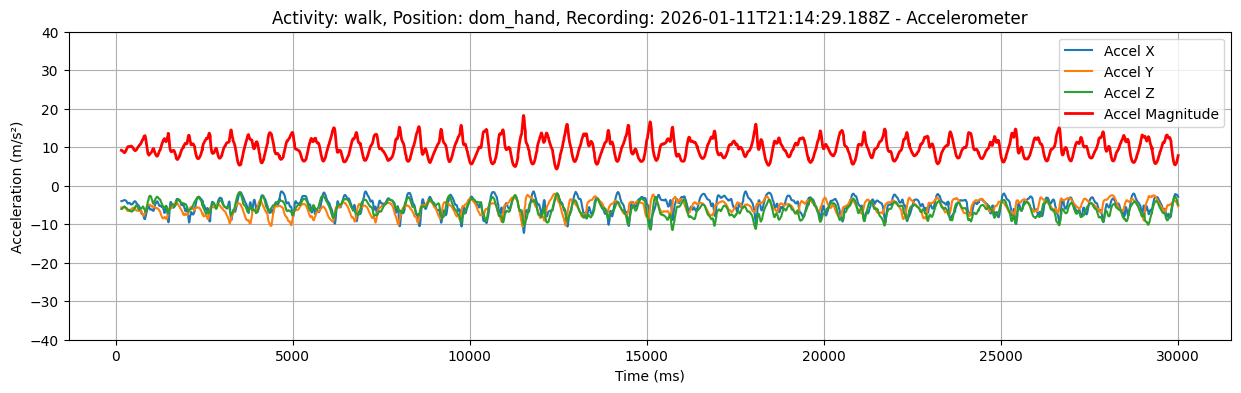

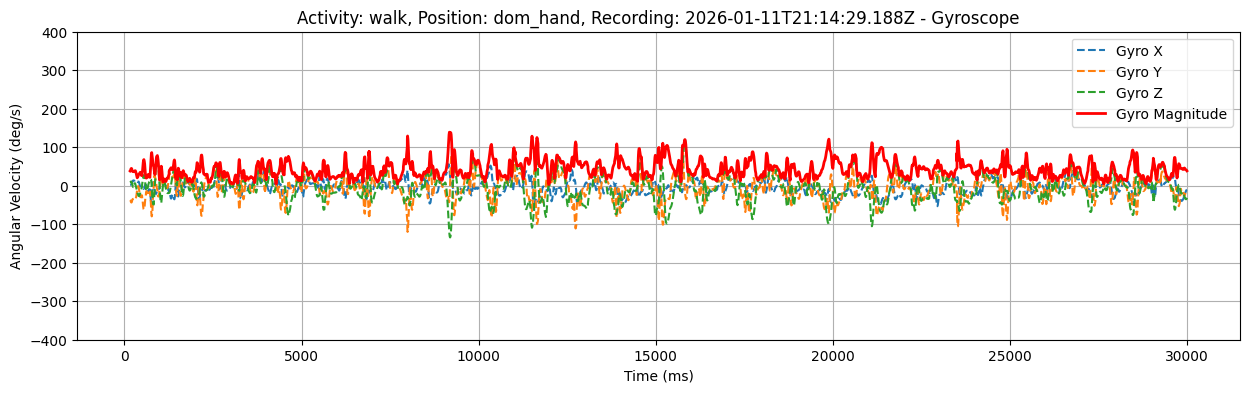

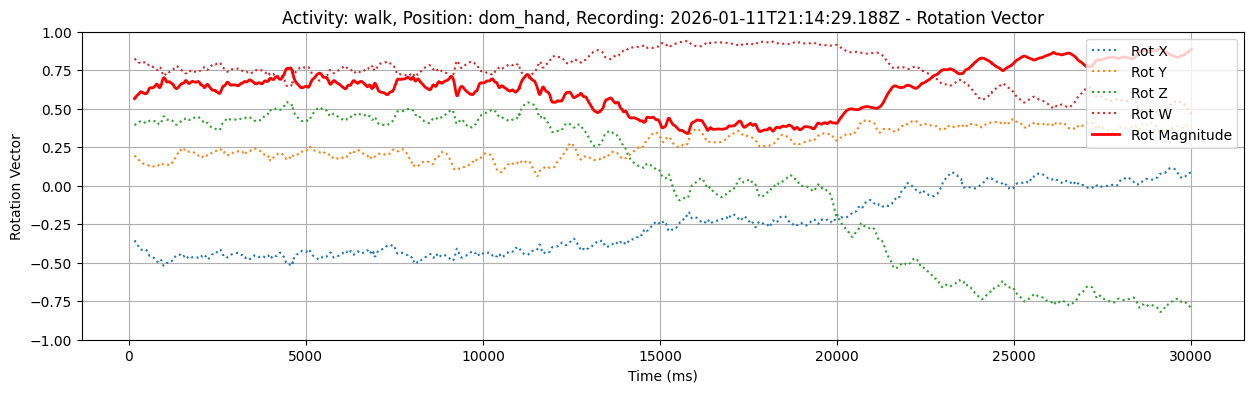

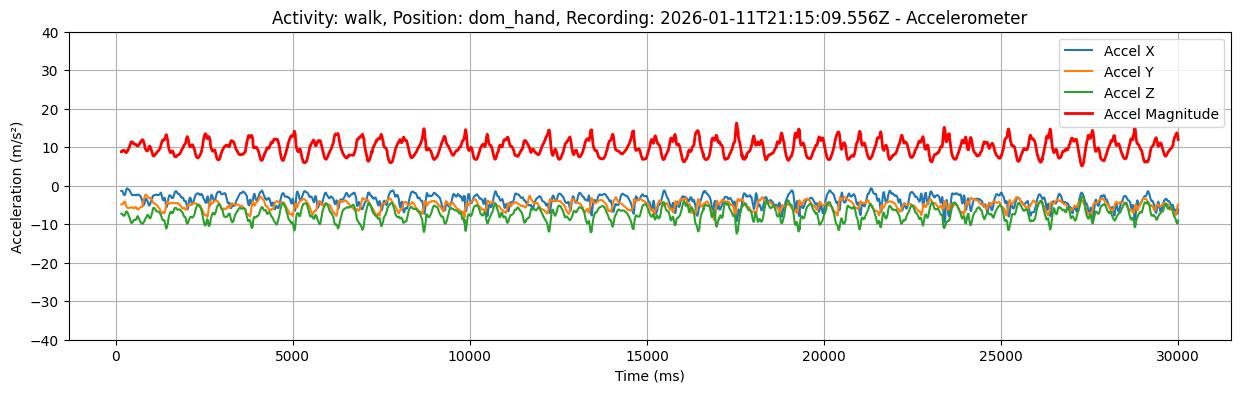

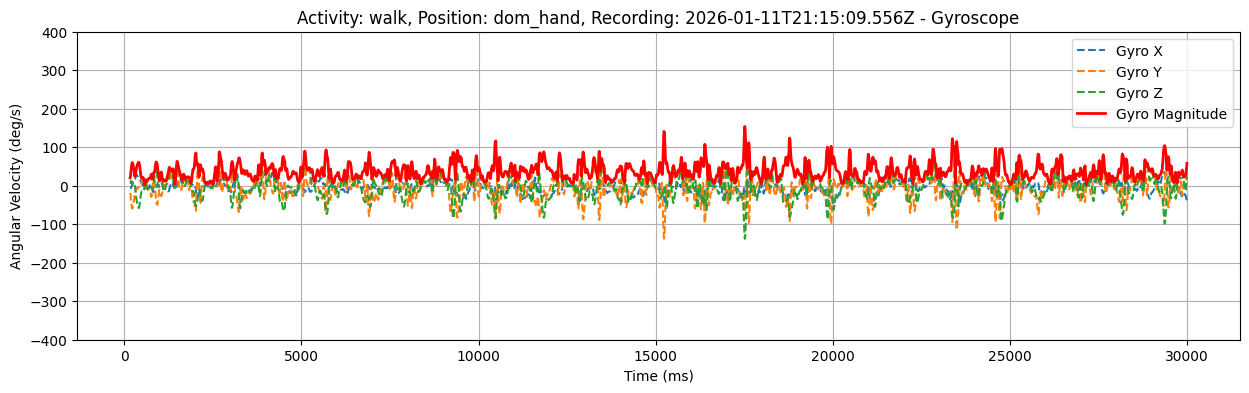

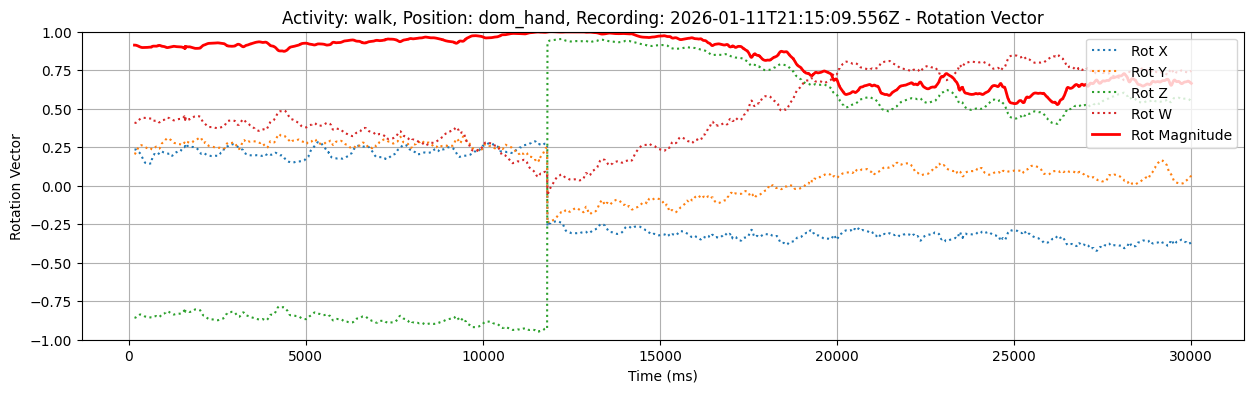

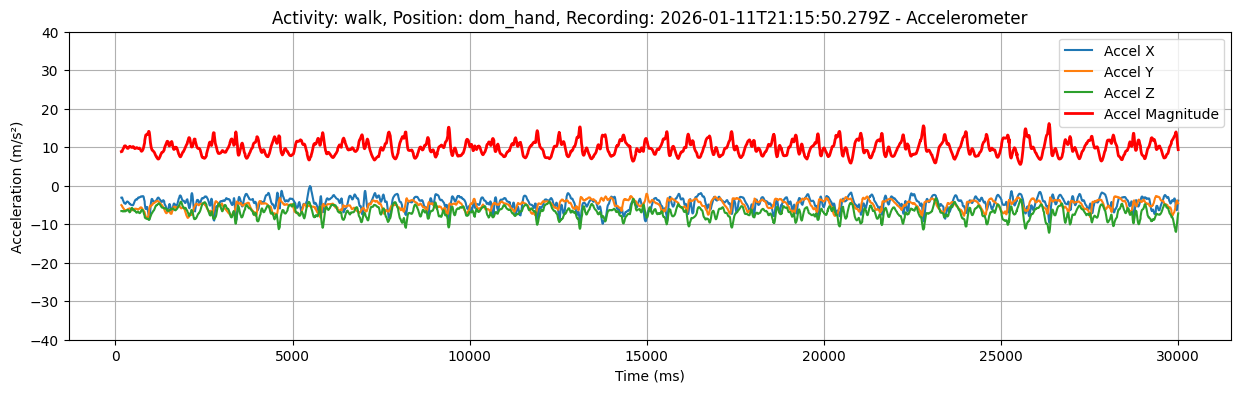

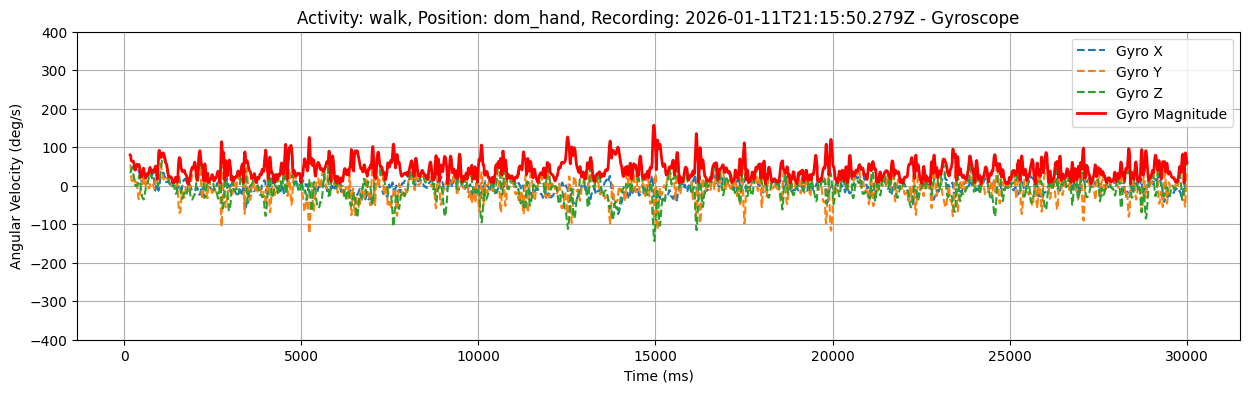

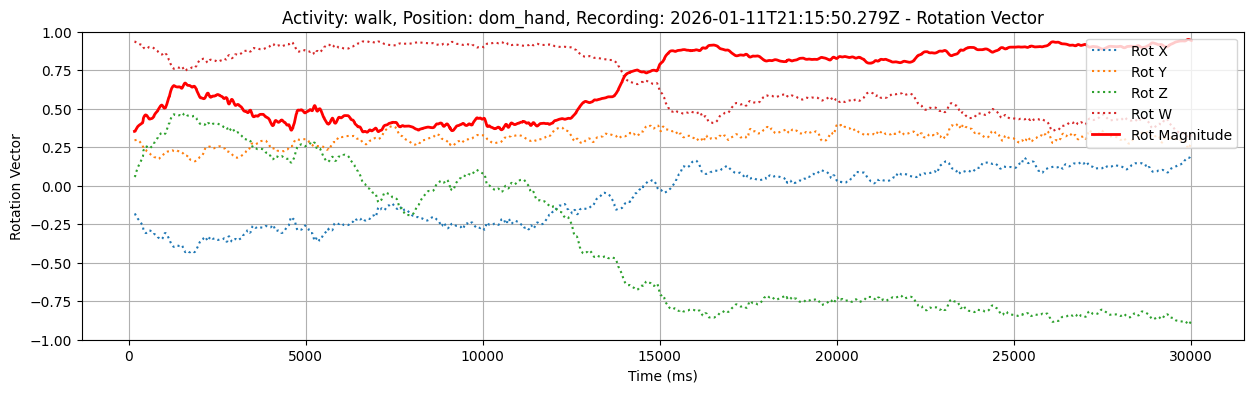

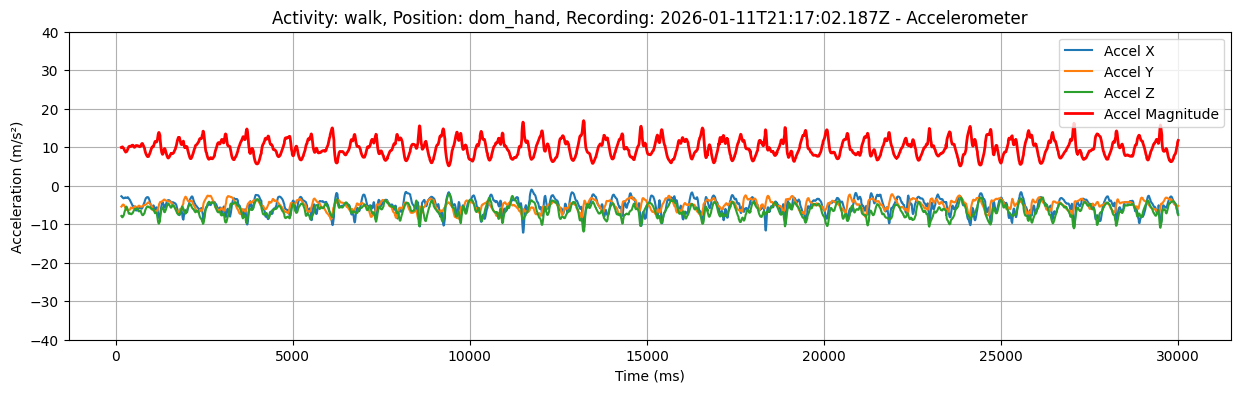

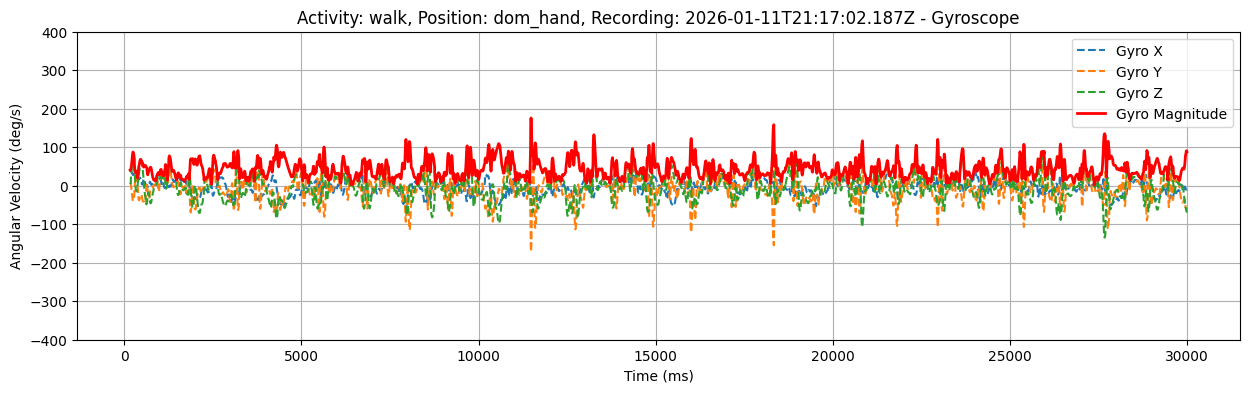

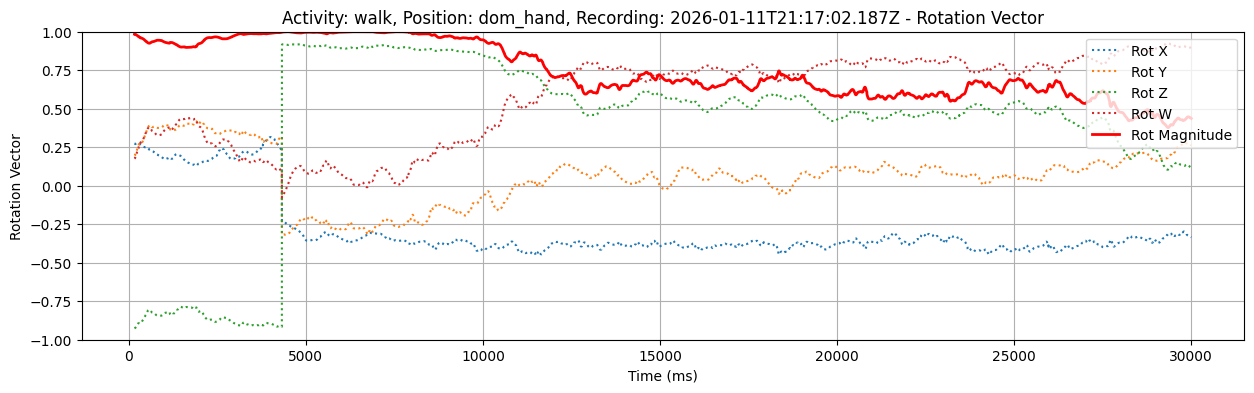

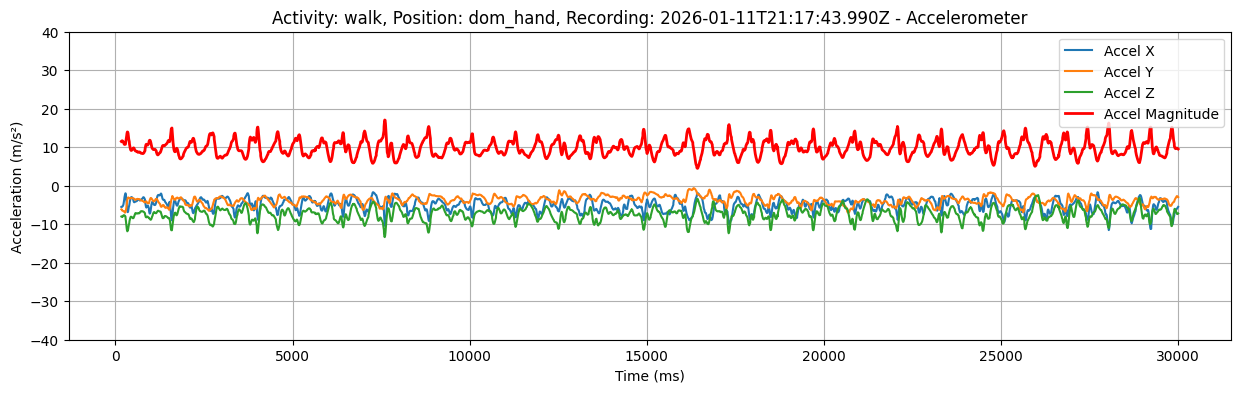

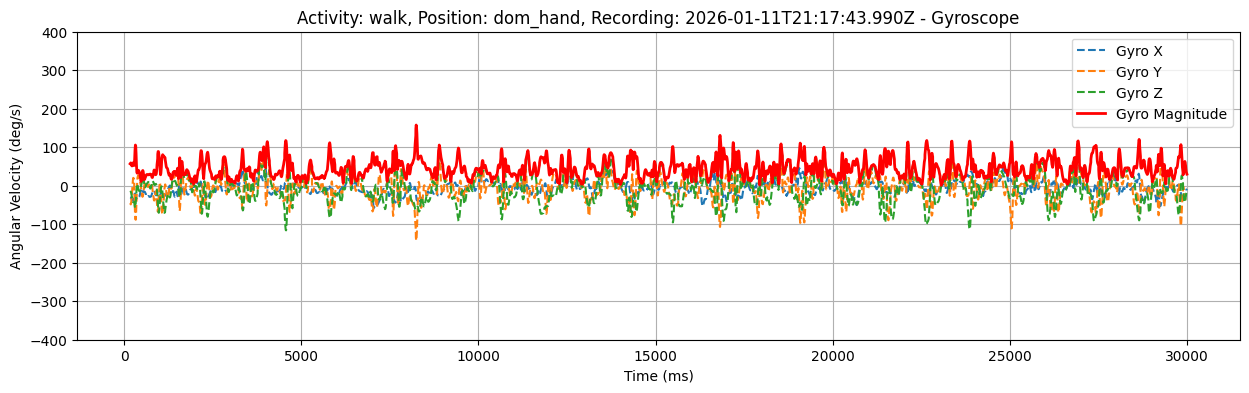

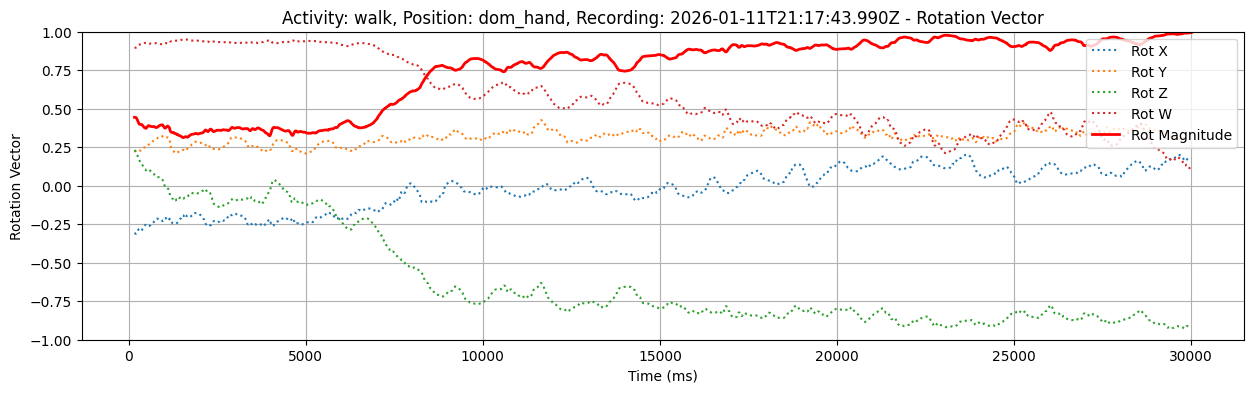

In [7]:
visualize_recordings(data, docs)